# Testing Machine Learning-Based Models with Nautilus Trader

References: 

https://github.com/limx0/nautilus_talks

In [1]:
# python >= 3.11
# !pip install -U ipykernel
# !pip install -U "nautilus-trader[ib]"
# !pip install -U "stable-baselines3[extra]"

## Imports

In [2]:
import os
import shutil
import datetime
import pandas as pd
import gymnasium as gym
from functools import partial
from typing import List, Tuple, Optional
from pathlib import Path
from decimal import Decimal
from trade_flow.core import TrainingNode

/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/trade_flow/feed/__init__.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, parse_dates=True, index_col=index_name)


In [3]:
from nautilus_trader.config import (
    LoggingConfig,
    CacheConfig,
    ActorConfig,
    StrategyConfig,
    BacktestDataConfig,
    BacktestEngineConfig,
    BacktestRunConfig,
    BacktestVenueConfig,
    ImportableActorConfig,
    ImportableStrategyConfig,
    RiskEngineConfig,
    StreamingConfig,
    StrategyConfig,
)

from nautilus_trader.common.actor import Actor, ActorConfig

from nautilus_trader.model.data import DataType
from nautilus_trader.model.data import Bar, BarType, BarSpecification
from nautilus_trader.model.enums import AggregationSource
from nautilus_trader.model.identifiers import InstrumentId, PositionId

from nautilus_trader.common.enums import LogColor
from nautilus_trader.core.data import Data
from nautilus_trader.core.datetime import secs_to_nanos, nanos_to_secs, unix_nanos_to_dt, dt_to_unix_nanos


from nautilus_trader.core.message import Event

from nautilus_trader.model.enums import OrderSide, PositionSide, TimeInForce
from nautilus_trader.model.events.position import (
    PositionChanged,
    PositionClosed,
    PositionEvent,
    PositionOpened,
)

from nautilus_trader.model.objects import Price, Quantity
from nautilus_trader.model.position import Position
from nautilus_trader.trading.strategy import Strategy

from nautilus_trader.model.functions import order_side_to_str

from nautilus_trader.persistence.wranglers import QuoteTickDataWrangler, BarDataWrangler
from nautilus_trader.persistence.catalog import ParquetDataCatalog # as DataCatalog

from nautilus_trader.test_kit.providers import CSVTickDataLoader
from nautilus_trader.test_kit.providers import TestInstrumentProvider


# from nautilus_trader.backtest.node import BacktestDataConfig
# from nautilus_trader.backtest.node import BacktestEngineConfig
from nautilus_trader.backtest.node import BacktestNode
# from nautilus_trader.backtest.node import BacktestRunConfig
# from nautilus_trader.backtest.node import BacktestVenueConfig
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.backtest.models import FillModel

from nautilus_trader.model.data import QuoteTick
from nautilus_trader.model.objects import Quantity
from nautilus_trader.model.data import Bar
from nautilus_trader.model.data import BarType
from nautilus_trader.model.identifiers import TraderId




## Collect Data

In [4]:
import yfinance as yf

def fetch_data(instrument_name: str, datetime_format: str = "mixed", interval: str = "1d", start: str = "2020-01-01", end: str = "2021-01-01,", venue: str = "NASDAQ"):
    data: Optional[pd.DataFrame] = yf.download(instrument_name, interval=interval, start=start, end=end)
    data.index = pd.to_datetime(data.index, format=datetime_format)
    data.drop(columns=['Adj Close'], axis=1, inplace=True)
    data.index.set_names("timestamp", inplace=True)

    # Process bars using a wrangler
    INSTRUMENT = TestInstrumentProvider.equity(symbol=instrument_name.upper(), venue=venue.upper())
    bar_tf = 'HOUR' if interval == '1h' else 'DAY'
    wrangler = BarDataWrangler(bar_type=BarType.from_str(f"{instrument_name.upper()}.{venue}-1-{bar_tf}-LAST-EXTERNAL"), instrument=INSTRUMENT)

    bars = wrangler.process(data)
    
    return INSTRUMENT, bars

# soxx_data = yf.download("SOXX", start="2020-01-01", end="2021-01-01")
# soxx_data

### Process Data

In [5]:
import hvplot.pandas
import holoviews as hv

from utils import bars_to_dataframe

# conda install hvplot

# CATALOG_PATH = Path.cwd() / "catalog"

# # Clear if it already exists, then create fresh
# if CATALOG_PATH.exists():
#     shutil.rmtree(CATALOG_PATH)
# CATALOG_PATH.mkdir(parents=True)

# # Create a catalog instance
# nautilus_talks_catalog = ParquetDataCatalog(CATALOG_PATH)

# # Write instrument to the catalog
# nautilus_talks_catalog.write_data([EURUSD])

# # Write ticks to catalog
# nautilus_talks_catalog.write_data(ticks)

In [6]:
smh_instrument, smh_bars = fetch_data("SMH", interval="1d", datetime_format="%Y-%m-%d %H:%M:%S.%f", start="2020-01-01", end="2023-01-01")
smh_instrument, smh_bars

[*********************100%***********************]  1 of 1 completed


(Equity(id=SMH.NASDAQ, raw_symbol=SMH, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 [Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.34,72.47,71.65,71.89,5200400,1577923200000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.15,71.71,70.94,71.28,9963600,1578009600000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,70.39,70.57,69.89,70.25,6514000,1578268800000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.57,71.82,70.70,71.12,6526000,1578355200000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.69,72.06,71.26,71.57,6112800,1578441600000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.10,72.61,71.42,72.61,6403600,1578528000000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.50,72.51,71.37,72.51,4503800,1578614400000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.50,72.53,71.84,72.10,7211800,

In [7]:
soxx_instrument, soxx_bars = fetch_data("SOXX", interval="1d", datetime_format="%Y-%m-%d %H:%M:%S.%f", start="2020-01-01", end="2023-01-01")
soxx_instrument, soxx_bars

[*********************100%***********************]  1 of 1 completed


(Equity(id=SOXX.NASDAQ, raw_symbol=SOXX, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 [Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.43,85.43,84.33,84.75,1275300,1577923200000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,83.84,84.57,83.65,84.11,1235100,1578009600000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,82.96,83.23,82.42,82.78,1615200,1578268800000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.49,84.82,83.50,84.00,1146600,1578355200000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.41,84.98,84.05,84.66,1297800,1578441600000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.95,85.59,84.15,85.59,639600,1578528000000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.45,85.49,84.21,85.49,1952100,1578614400000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.44,85.56,84.78,85.04

In [8]:
CATALOG_PATH = Path.cwd() / "catalog"

# Clear if it already exists, then create fresh
if CATALOG_PATH.exists():
    shutil.rmtree(CATALOG_PATH)
CATALOG_PATH.mkdir(parents=True)

# Create a catalog instance
nautilus_talks_catalog = ParquetDataCatalog(CATALOG_PATH)

# Write instrument to the catalog
nautilus_talks_catalog.write_data([smh_instrument, soxx_instrument])

# Write bars to catalog
nautilus_talks_catalog.write_data(smh_bars)
nautilus_talks_catalog.write_data(soxx_bars)

In [9]:
nautilus_talks_catalog_path = str(Path.cwd().joinpath("catalog"))
nautilus_talks_catalog_path

'/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/examples/nt_example/catalog'

In [10]:

os.listdir(nautilus_talks_catalog_path)

['data']

In [11]:
# CATALOG = DataCatalog(str(pathlib.Path(__file__).parent.joinpath("catalog")))
nautilus_talks_catalog = ParquetDataCatalog(nautilus_talks_catalog_path)

nautilus_talks_catalog.instruments()

[Equity(id=SMH.NASDAQ, raw_symbol=SMH, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 Equity(id=SOXX.NASDAQ, raw_symbol=SOXX, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None)]

In [12]:
# Load pre-loaded sample data from nautilus DataCatalog
src_id = 'SMH.NASDAQ'
tgt_id = 'SOXX.NASDAQ'

src = nautilus_talks_catalog.bars(instrument_ids=[src_id], start=pd.Timestamp('2020-01-01'), end=pd.Timestamp('2023-01-01'), as_nautilus=True)
tgt = nautilus_talks_catalog.bars(instrument_ids=[tgt_id], start=pd.Timestamp('2020-01-01'), end=pd.Timestamp('2023-01-01'), as_nautilus=True)

In [13]:
src 

[Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.34,72.47,71.65,71.89,5200400,1577923200000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.15,71.71,70.94,71.28,9963600,1578009600000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,70.39,70.57,69.89,70.25,6514000,1578268800000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.57,71.82,70.70,71.12,6526000,1578355200000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.69,72.06,71.26,71.57,6112800,1578441600000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.10,72.61,71.42,72.61,6403600,1578528000000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.50,72.51,71.37,72.51,4503800,1578614400000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.50,72.53,71.84,72.10,7211800,1578873600000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.65,73.14,72.21,72.59,6001800,1578960000000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.57,72.46,71.37,72.36,7379800,1579046400000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.73,72.73,72.15,72.24,6238400,1579132800000000000),
 Bar(SMH.N

In [14]:
tgt

[Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.43,85.43,84.33,84.75,1275300,1577923200000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,83.84,84.57,83.65,84.11,1235100,1578009600000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,82.96,83.23,82.42,82.78,1615200,1578268800000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.49,84.82,83.50,84.00,1146600,1578355200000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.41,84.98,84.05,84.66,1297800,1578441600000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.95,85.59,84.15,85.59,639600,1578528000000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.45,85.49,84.21,85.49,1952100,1578614400000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.44,85.56,84.78,85.04,950100,1578873600000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.63,86.35,85.18,85.67,896400,1578960000000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.72,85.79,84.37,85.75,1516500,1579046400000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,86.06,86.09,85.31,85.37,1708500,1579132800000000000),
 B

In [15]:
# Merge into single Dataframe for convenience, filter for market hours only
df = bars_to_dataframe({src_id: src, tgt_id: tgt}, columns=["close"])
# df.index = pd.to_datetime(df.index)

/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/examples/nt_example/utils.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = pd.concat(all_dataframes)[columns].unstack(0).sort_index().fillna(method="ffill")


In [16]:
df_time = df.between_time(datetime.time(14, 30), datetime.time(21,0))
df_time

Empty DataFrame
Columns: [(close, SMH.NASDAQ), (close, SOXX.NASDAQ)]
Index: []

In [17]:
df

close            
instrument_id SMH.NASDAQ SOXX.NASDAQ
ts_init                             
2020-01-02         71.89       84.75
2020-01-03         71.28       84.11
2020-01-06         70.25       82.78
2020-01-07         71.12       84.00
2020-01-08         71.57       84.66
...                  ...         ...
2022-12-23        101.04      115.19
2022-12-27        101.04      115.37
2022-12-28         99.47      113.46
2022-12-29        100.21      114.34
2022-12-30        100.35      114.44

[756 rows x 2 columns]

In [18]:
df.columns

MultiIndex([('close',  'SMH.NASDAQ'),
            ('close', 'SOXX.NASDAQ')],
           names=[None, 'instrument_id'])

## Supervised Learning 

### Pairs Trading Analysis

#### Premise
- Two (or more) assets prices are related in some way
- Their prices typically move together
- Opportunities arise when one assert deviates from the relationship
- Buy one, sell the other with the expectation they will return to their relationship at some point in the future

#### Benefits
- Applicable to a wide range of markets & assets
- market neutral (if the market suddenly tanks, don't lose money)

#### Challenges
- Modelling the relationship (drifting pairs)
- Transaction costs
- Getting "legged"

#### Example
- Two semiconductor ETFs `SMH` (VanEck Semiconductor ETF) and `SOXX` (iShares Semiconductor ETF)
- Fundamental reasons for a relationship (both ETFs of similar stocks)
- Visual analysis of price series confirms belief of relationship

In [19]:
import matplotlib.pyplot as plt

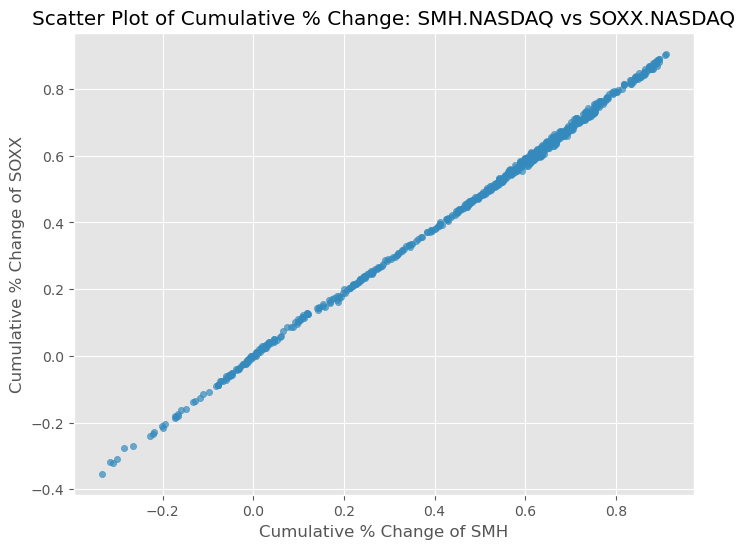

In [20]:
# Scatter plot of SMH vs SOXX cumulative percentage changes
df.pct_change().cumsum()['close'].plot.scatter(
    x=src_id, 
    y=tgt_id, 
    figsize=(8, 6), 
    title=f"Scatter Plot of Cumulative % Change: {src_id} vs {tgt_id}", 
    # color='blue', 
    alpha=0.7, 
    grid=True
)

# Adding axis labels
plt.xlabel("Cumulative % Change of SMH")
plt.ylabel("Cumulative % Change of SOXX")
plt.show()


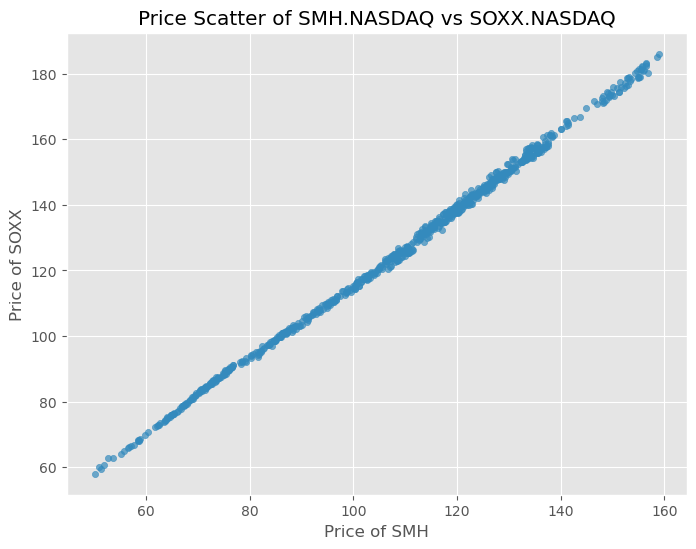

In [21]:
# Scatter plot of SMH vs SOXX price
df['close'].plot.scatter(
    x=src_id, 
    y=tgt_id, 
    figsize=(8, 6), 
    title=f"Price Scatter of {src_id} vs {tgt_id}", 
    # color='blue', 
    alpha=0.7, 
    grid=True
)

# Adding axis labels
plt.xlabel("Price of SMH")
plt.ylabel("Price of SOXX")
plt.show()


In [22]:
# Format values for scikit-learn
X = df['close'].loc[:, src_id].astype(float).values.reshape(-1, 1)
Y = df['close'].loc[:, tgt_id].astype(float).values.reshape(-1, 1)

In [23]:
# Fit a model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

LinearRegression(fit_intercept=False)

### Setup Nautilus Training Node

#### Define Model

In [24]:
def create_prediction_actor(instrument_ids: Tuple[str, str]) -> ImportableActorConfig:
    """Creates the configuration for the model prediction actor."""
    return ImportableActorConfig(
        actor_path="model:PredictedPriceActor",
        config_path="model:PredictedPriceConfig",
        config=dict(
            source_symbol=instrument_ids[0],
            target_symbol=instrument_ids[1],
        ),
    )


#### Define Strategy

In [25]:
def create_strategy_config(instrument_ids: Tuple[str, str], notional_trade_size_usd: int, **strategy_kwargs) -> ImportableStrategyConfig:
    """Creates the configuration for the trading strategy."""
    return ImportableStrategyConfig(
        strategy_path="strategy:PairTrader",
        config_path="strategy:PairTraderConfig",
        config=dict(
            source_symbol=instrument_ids[0],
            target_symbol=instrument_ids[1],
            notional_trade_size_usd=notional_trade_size_usd,
            **strategy_kwargs,
        ),
    )

#### Run Model Backtest/Training

In [26]:
def create_backtest_engine_config(catalog: ParquetDataCatalog, prediction: ActorConfig, strategy: StrategyConfig, 
                           persistence: bool, log_level: str, bypass_logging: bool) -> BacktestEngineConfig:
    """Creates the configuration for the backtest engine."""
    return BacktestEngineConfig(
        trader_id="BACKTESTER-001",
        cache=CacheConfig(tick_capacity=100_000),
        # bypass_logging=bypass_logging,
        # log_level=log_level,
        streaming=StreamingConfig(catalog_path=str(catalog.path)) if persistence else None,
        risk_engine=RiskEngineConfig(max_order_submit_rate="1000/00:00:01"),
        strategies=[strategy],
        actors=[prediction],
    )


def main(
    instrument_ids: Tuple[str, str],
    catalog: ParquetDataCatalog,
    notional_trade_size_usd: int = 10_000,
    start_time: str = None,
    end_time: str = None,
    log_level: str = "ERROR",
    bypass_logging: bool = False,
    persistence: bool = False,
    **strategy_kwargs,
):
    # Setup configurations
    prediction = create_prediction_actor(instrument_ids)
    strategy = create_strategy_config(instrument_ids, notional_trade_size_usd, **strategy_kwargs)
    engine_config = create_backtest_engine_config(catalog, prediction, strategy, persistence, log_level, bypass_logging)

    venues = [
        BacktestVenueConfig(
            name="NASDAQ", 
            oms_type="NETTING",
            account_type="CASH",
            base_currency="USD",
            starting_balances=["1_000_000 USD"],
        )
    ]

    data = [
        BacktestDataConfig(
            data_cls=Bar.fully_qualified_name(),
            catalog_path=str(catalog.path),
            catalog_fs_protocol=catalog.fs_protocol,
            catalog_fs_storage_options=catalog.fs_storage_options,
            instrument_id=InstrumentId.from_str(instrument_id),
            start_time=start_time,
            end_time=end_time,
        )
        for instrument_id in instrument_ids
    ]

    run_config = BacktestRunConfig(engine=engine_config, venues=venues, data=data)
    
    print("venues => ", run_config.venues)
    node = TrainingNode(configs=[run_config])
    return node.run()


In [27]:
# # typer.run(main)
# # lr_catalog = LR_MODEL_DATA_CATALOG

# assert len(nautilus_talks_catalog.instruments())>0, "Couldn't load instruments, have you run `poetry run inv extract-catalog`?"

# [result] = main(
#         catalog=nautilus_talks_catalog,
#         instrument_ids=("SMH.NASDAQ", "SOXX.NASDAQ"),
#         # instrument_ids=("EURUSD.SIM"),
#         log_level="INFO",
#         persistence=False,
#         end_time="2020-06-01",
#     )


In [28]:
# result

In [29]:
# print(result.instance_id)

## Reinforcement Learning 

### Create Env

In [30]:
import time
from decimal import Decimal
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.config import LoggingConfig
from nautilus_trader.examples.algorithms.twap import TWAPExecAlgorithm
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
from nautilus_trader.model.currencies import ETH
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.data import BarType
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import TraderId
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.model.objects import Money
from nautilus_trader.persistence.wranglers import TradeTickDataWrangler
from nautilus_trader.test_kit.providers import TestDataProvider
from nautilus_trader.test_kit.providers import TestInstrumentProvider

from trade_flow.environments.default import actions, informers, observers, renderers, rewards, stoppers
from trade_flow.environments.default.engine.portfolio import Portfolio
from trade_flow.environments.default.engine.execution.simulated import execute_order
from trade_flow.environments.default.engine.instruments import USD, BTC
from trade_flow.environments.default.engine.wallet import Wallet
from trade_flow.environments.default.engine.exchanges import Exchange
from trade_flow.feed import Stream, DataFeed, NameSpace, Coinbase_BTCUSD_d


In [31]:
def encode_symbols(data):
    """Encodes the currency symbols in the data using one-hot or label encoding.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        pandas.DataFrame: The DataFrame with the one-hot encoded symbols.
    """

    # Extract currency pairs
    symbols = data["symbol"].unique()

    # Create a vocabulary mapping
    vocabulary = {pair: i for i, pair in enumerate(symbols)}

    data["symbol_encoded"] = data["symbol"].apply(lambda pair: vocabulary[pair])

    # One-hot encode the symbols
    # data = pd.get_dummies(data, columns=["symbol_encoded"], prefix="")

    return data, vocabulary

def get_env_data(df: pd.DataFrame = Coinbase_BTCUSD_d):
    print("df.head(): ", df.head())

    dataset = df.reset_index()
    print("dataset.head(3): ", dataset.head(3))

    price_history = dataset[["date", "open", "high", "low", "close", "volume"]]  # chart data
    print("price_history: ", price_history.head(3))

    dataset.drop(columns=["date", "open", "high", "low", "close", "volume"], inplace=True)
    print("dataset: ", dataset)

    dataset_encoded, vocabulary = encode_symbols(dataset)
    print("vocabulary: ", vocabulary)
    print("dataset_encoded: ", dataset_encoded)

    dataset_encoded = dataset_encoded[["symbol_encoded", "volume_btc"]]
    print("dataset_encoded: ", dataset_encoded)

    selected_dataset = dataset_encoded
    print("selected_dataset: ", selected_dataset)

    coinbase = Exchange("coinbase", service=execute_order)(
        Stream.source(price_history["close"].tolist(), dtype="float").rename("USD-BTC")
    )

    portfolio = Portfolio(
        USD,
        [
            Wallet(coinbase, 1000 * USD),
            Wallet(coinbase, 1 * BTC),
        ],
    )

    with NameSpace("coinbase"):
        streams = [
            Stream.source(selected_dataset[c].tolist(), dtype=selected_dataset[c].dtype).rename(c)
            for c in selected_dataset.columns
        ]

    feed = DataFeed(streams)
    print("feed.next(): ", feed.next())

    return portfolio, feed


In [32]:

def create_portfolio(price_history: pd.DataFrame) -> Portfolio:
    """
    Creates a default portfolio with initial USD and BTC balance for a Coinbase exchange.

    Parameters:
    ----------
        price_history (pd.DataFrame): The DataFrame containing the price history.

    Returns:
    -------
        Portfolio: A trading portfolio containing USD and BTC.
    """
    coinbase = Exchange("coinbase", service=execute_order)(
        Stream.source(price_history["close"].tolist(), dtype=price_history["close"].dtype).rename(
            "USD-BTC"
        )  # TODO: fix Exception: No stream satisfies selector condition. for `multiple stream sources`
    )
    return Portfolio(
        USD,
        [
            Wallet(coinbase, 1000 * USD),
            Wallet(coinbase, 1 * BTC),
        ],
    )


# Configure backtest engine
config = BacktestEngineConfig(
        trader_id=TraderId("TRAINER-001"),
        logging=LoggingConfig(
            log_level="INFO",
            log_colors=True,
            bypass_logging=False,
            use_pyo3=False,
        ),
    )

# Add a trading venue (multiple venues possible)
BINANCE = Venue("BINANCE")

min_periods = None
random_start_pct = 0.00

portfolio, feed = get_env_data()


observer = observers.TradeFlowObserver(
        portfolio=portfolio,
        feed=feed,
        renderer_feed=None,
        window_size=1,
        min_periods=min_periods,
    )
stopper = stoppers.MaxLossStopper(max_allowed_loss=0.5)
informer = informers.TradeFlowInformer()

action_scheme = actions.get("simple")
action_scheme.portfolio = portfolio

reward_scheme = rewards.get("simple")
renderer = renderers.get("screen-log")



df.head():              symbol     open     high      low    close  volume_btc  \
date                                                                 
2019-10-17  BTCUSD  7993.54  8070.00  7937.01  8034.32     1570.08   
2019-10-16  BTCUSD  8162.44  8171.59  7908.86  7993.54     8123.72   
2019-10-15  BTCUSD  8355.00  8420.00  8085.65  8162.44     7919.56   
2019-10-14  BTCUSD  8282.97  8409.00  8215.66  8355.00     4401.82   
2019-10-13  BTCUSD  8309.03  8469.02  8146.47  8282.97     5459.53   

                 volume  
date                     
2019-10-17  12537245.82  
2019-10-16  65132771.81  
2019-10-15  65109952.98  
2019-10-14  36575829.05  
2019-10-13  45492326.33  
dataset.head(3):          date  symbol     open     high      low    close  volume_btc  \
0 2019-10-17  BTCUSD  7993.54  8070.00  7937.01  8034.32     1570.08   
1 2019-10-16  BTCUSD  8162.44  8171.59  7908.86  7993.54     8123.72   
2 2019-10-15  BTCUSD  8355.00  8420.00  8085.65  8162.44     7919.56   

        

In [33]:
from gymnasium.envs.registration import register

register(
    id='nautilus-trader-v0',
    entry_point='trade_flow.environments.nautilus_trader:NautilusTraderEnv',
    kwargs={
        'engine_config': config,
        'action_scheme': action_scheme,
        'reward_scheme': reward_scheme,
        'observer': observer,
        'stopper': stopper,
        'informer': informer,
        'renderer': renderer,
        'min_periods': min_periods,
        'max_episode_steps':  None,
        'random_start_pct': random_start_pct,
        'venue': BINANCE,
        'oms_type': OmsType.NETTING,
        'account_type': AccountType.CASH,  # Spot CASH account (not for perpetuals or futures)
        'base_currency': None,  # Multi-currency account
        'starting_balances': [Money(1_000_000.0, USDT), Money(10.0, ETH)],
    }
)


In [34]:
env_name = 'nautilus-trader-v0'

env = gym.make(env_name)

ImportError: Missing module "rsa", please install via pip.

In [35]:
state = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, _, info = env.step(action)

# Communication with the engine will be done through an actor take a look at nautilus_talks repo or the nt_example. 


2024-11-07T19:13:20.706146401Z [INFO] TRAINER-001.DataEngine: READY
2024-11-07T19:13:20.706188305Z [INFO] TRAINER-001.ExecClient-BINANCE: READY
2024-11-07T19:13:20.706210034Z [INFO] TRAINER-001.Cache: Reset
2024-11-07T19:13:20.706217498Z [INFO] TRAINER-001.ExecEngine: READY
2024-11-07T19:13:20.706254614Z [INFO] TRAINER-001.RiskEngine: READY
2024-11-07T19:13:20.706305145Z [INFO] TRAINER-001.OrderEmulator: READY
2024-11-07T19:13:20.706574799Z [INFO] TRAINER-001.Portfolio: READY
2024-11-07T19:13:20.706599711Z [INFO] TRAINER-001.TRAINER-001: READY
2024-11-07T19:13:20.706780973Z [INFO] TRAINER-001.Portfolio: Updated AccountState(account_id=BINANCE-001, account_type=CASH, base_currency=None, is_reported=True, balances=[AccountBalance(total=1_000_000.00000000 USDT, locked=0.00000000 USDT, free=1_000_000.00000000 USDT), AccountBalance(total=10.00000000 ETH, locked=0.00000000 ETH, free=10.00000000 ETH)], margins=[], event_id=cefc77f3-7cc8-4539-ab32-2d10e13df3f6)
2024-11-07T19:13:20.706789500Z [

/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [368]:
stop

NameError: name 'stop' is not defined

In [ ]:
# put the calculate_reward function in the nautilus trader strategy, so that a user can write reward functions in it

# the environment will be inside the training node, a dataframe will be passed to it containing the data fro the environment,
# by using this approach any environment written in gymnasium can be embedded inside the training node  


# DUMP

In [ ]:
# print(engine.trader.generate_account_report(BINANCE))
# print(engine.trader.generate_order_fills_report())
# print(engine.trader.generate_positions_report())

In [63]:
# # env_name = 'forex-hedge-v0'
# # env_name = 'stocks-hedge-v0'
# env_name = 'crypto-hedge-v0'
# # env_name = 'mixed-hedge-v0'

# # env_name = 'forex-unhedge-v0'
# # env_name = 'stocks-unhedge-v0'
# # env_name = 'crypto-unhedge-v0'
# # env_name = 'mixed-unhedge-v0'

# env = gym.make(env_name)

In [64]:

# class NautilusTraderEnv(gym.Env):
#     def __init__(self):
#         # Initialize Nautilus Trader instance
#         self.engine = BacktestEngine(symbol, start_date, end_date)
#         # Define observation and action spaces
#         self.observation_space = ...
#         self.action_space = ...

#     def step(self, action):
#         # Execute action in Nautilus Trader
#         self.engine.execute_action(action)
#         # Get new state and reward
#         new_state = self.engine.get_state()
#         reward = self.calculate_reward()
#         done = self.is_done()
#         return new_state, reward, done, {}

#     def reset(self):
#         # Reset Nautilus Trader and return initial state
#         self.engine.reset()
#         return self.engine.get_state()

#     def render(self, mode='human'):
#         # Visualize the trading environment (optional)
#         pass

#     def calculate_reward(self):
#         # Calculate reward based on profit/loss, risk metrics, etc.
#         return reward


In [ ]:
# #!/usr/bin/env python3
# # -------------------------------------------------------------------------------------------------
# #  Copyright (C) 2015-2024 Nautech Systems Pty Ltd. All rights reserved.
# #  https://nautechsystems.io
# #
# #  Licensed under the GNU Lesser General Public License Version 3.0 (the "License");
# #  You may not use this file except in compliance with the License.
# #  You may obtain a copy of the License at https://www.gnu.org/licenses/lgpl-3.0.en.html
# #
# #  Unless required by applicable law or agreed to in writing, software
# #  distributed under the License is distributed on an "AS IS" BASIS,
# #  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# #  See the License for the specific language governing permissions and
# #  limitations under the License.
# # -------------------------------------------------------------------------------------------------

# import time
# from decimal import Decimal

# import pandas as pd

# from nautilus_trader.backtest.engine import BacktestEngine
# from nautilus_trader.backtest.engine import BacktestEngineConfig
# from nautilus_trader.config import LoggingConfig
# from nautilus_trader.examples.algorithms.twap import TWAPExecAlgorithm
# from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
# from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
# from nautilus_trader.model.currencies import ETH
# from nautilus_trader.model.currencies import USDT
# from nautilus_trader.model.data import BarType
# from nautilus_trader.model.enums import AccountType
# from nautilus_trader.model.enums import OmsType
# from nautilus_trader.model.identifiers import TraderId
# from nautilus_trader.model.identifiers import Venue
# from nautilus_trader.model.objects import Money
# from nautilus_trader.persistence.wranglers import TradeTickDataWrangler
# from nautilus_trader.test_kit.providers import TestDataProvider
# from nautilus_trader.test_kit.providers import TestInstrumentProvider


# if __name__ == "__main__":
#     # Configure backtest engine
#     config = BacktestEngineConfig(
#         trader_id=TraderId("BACKTESTER-001"),
#         logging=LoggingConfig(
#             log_level="INFO",
#             log_colors=True,
#             use_pyo3=False,
#         ),
#     )

#     # Build the backtest engine
#     engine = BacktestEngine(config=config)

#     # Add a trading venue (multiple venues possible)
#     BINANCE = Venue("BINANCE")
#     engine.add_venue(
#         venue=BINANCE,
#         oms_type=OmsType.NETTING,
#         account_type=AccountType.CASH,  # Spot CASH account (not for perpetuals or futures)
#         base_currency=None,  # Multi-currency account
#         starting_balances=[Money(1_000_000.0, USDT), Money(10.0, ETH)],
#     )

#     # Add instruments
#     ETHUSDT_BINANCE = TestInstrumentProvider.ethusdt_binance()
#     engine.add_instrument(ETHUSDT_BINANCE)

#     # Add data
#     provider = TestDataProvider()
#     wrangler = TradeTickDataWrangler(instrument=ETHUSDT_BINANCE)
#     ticks = wrangler.process(provider.read_csv_ticks("binance/ethusdt-trades.csv"))
#     engine.add_data(ticks)

#     # Configure your strategy
#     config = EMACrossTWAPConfig(
#         instrument_id=ETHUSDT_BINANCE.id,
#         bar_type=BarType.from_str("ETHUSDT.BINANCE-250-TICK-LAST-INTERNAL"),
#         trade_size=Decimal("0.10"),
#         fast_ema_period=10,
#         slow_ema_period=20,
#         twap_horizon_secs=10.0,
#         twap_interval_secs=2.5,
#     )

#     # Instantiate and add your strategy
#     strategy = EMACrossTWAP(config=config)
#     engine.add_strategy(strategy=strategy)

#     # Instantiate and add your execution algorithm
#     exec_algorithm = TWAPExecAlgorithm()
#     engine.add_exec_algorithm(exec_algorithm)

#     time.sleep(0.1)
#     input("Press Enter to continue...")

#     # Run the engine (from start to end of data)
#     engine.run()

#     # Optionally view reports
#     with pd.option_context(
#         "display.max_rows",
#         100,
#         "display.max_columns",
#         None,
#         "display.width",
#         300,
#     ):
#         print(engine.trader.generate_account_report(BINANCE))
#         print(engine.trader.generate_order_fills_report())
#         print(engine.trader.generate_positions_report())

#     # For repeated backtest runs make sure to reset the engine
#     engine.reset()

#     # Good practice to dispose of the object
#     engine.dispose()
